In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import joblib
from sklearn.metrics import precision_score, recall_score, ndcg_score
import matplotlib.pyplot as plt

# Load the engineered features
video_features = pd.read_csv('video_features_engineered.csv')
user_features = pd.read_csv('user_features_engineered.csv')
interactions = pd.read_csv('interactions_with_features.csv')

# Load the user-item matrix for later evaluation
user_item_indices = joblib.load('user_item_indices.pkl')

In [2]:
# Select content features for videos
content_features = [
    'avg_watch_ratio', 'complete_view_ratio', 'like_engagement', 
    'comment_engagement', 'share_engagement', 'daily_popularity'
]

# Create the feature matrix
video_feature_matrix = video_features[content_features].values

# We'll use cosine similarity to measure similarity between videos
video_similarity = cosine_similarity(video_feature_matrix)

# Create a mapping of video_id to index in the similarity matrix
video_to_idx = {video_id: i for i, video_id in enumerate(video_features['video_id'])}
idx_to_video = {i: video_id for video_id, i in video_to_idx.items()}

In [4]:
class ContentBasedRecommender:
    def __init__(self, video_features, video_similarity, video_to_idx, idx_to_video):
        self.video_features = video_features
        self.video_similarity = video_similarity
        self.video_to_idx = video_to_idx
        self.idx_to_video = idx_to_video
    
    def recommend_for_user(self, user_id, user_interactions, top_n=10):
        """
        Generate content-based recommendations for a user
        
        Args:
            user_id: ID of the user
            user_interactions: DataFrame of user interactions
            top_n: Number of recommendations to return
            
        Returns:
            List of recommended video IDs
        """
        # Get videos the user has watched with watch_ratio > 0.7 (indicating they liked it)
        user_liked_videos = user_interactions[
            (user_interactions['user_id'] == user_id) & 
            (user_interactions['watch_ratio'] > 0.7)
        ]['video_id'].unique()
        
        # If user hasn't watched any videos, return most popular videos
        if len(user_liked_videos) == 0:
            return self.video_features.sort_values('daily_popularity', ascending=False)['video_id'].head(top_n).tolist()
        
        # Get videos the user has already watched
        user_watched_videos = user_interactions[user_interactions['user_id'] == user_id]['video_id'].unique()
        
        # Calculate recommendation scores based on similarity to liked videos
        recommendation_scores = {}
        
        for video_id in user_liked_videos:
            if video_id in self.video_to_idx:
                video_idx = self.video_to_idx[video_id]
                # Get similarity scores for this video compared to all others
                similar_videos = self.video_similarity[video_idx]
                
                # Update recommendation scores
                for idx, score in enumerate(similar_videos):
                    rec_video_id = self.idx_to_video[idx]
                    # Skip videos the user has already watched
                    if rec_video_id not in user_watched_videos:
                        recommendation_scores[rec_video_id] = recommendation_scores.get(rec_video_id, 0) + score
        
        # Sort videos by recommendation score
        recommended_videos = sorted(recommendation_scores.items(), key=lambda x: x[1], reverse=True)
        
        # Return top N video IDs
        return [video_id for video_id, score in recommended_videos[:top_n]]

In [5]:
from sklearn.model_selection import train_test_split

# Group by user for stratified splitting
user_groups = interactions.groupby('user_id')

# Initialize empty DataFrames
train_interactions = pd.DataFrame()
test_interactions = pd.DataFrame()

# Split each user's interactions
for user_id, group in user_groups:
    # For each user, take 80% as training and 20% as testing
    user_train, user_test = train_test_split(group, test_size=0.2, random_state=42)
    train_interactions = pd.concat([train_interactions, user_train])
    test_interactions = pd.concat([test_interactions, user_test])

# Reset indices
train_interactions = train_interactions.reset_index(drop=True)
test_interactions = test_interactions.reset_index(drop=True)

# Create the recommender with training data
content_recommender = ContentBasedRecommender(
    video_features, 
    video_similarity, 
    video_to_idx, 
    idx_to_video
)

In [6]:
def precision_at_k(recommended_items, relevant_items, k):
    """
    Calculate precision@k
    """
    # Only consider the top-k items
    recommended_items = recommended_items[:k]
    # Count the number of relevant items in the recommendations
    hits = len(set(recommended_items) & set(relevant_items))
    # Calculate precision
    precision = hits / k if k > 0 else 0
    return precision

def recall_at_k(recommended_items, relevant_items, k):
    """
    Calculate recall@k
    """
    # Only consider the top-k items
    recommended_items = recommended_items[:k]
    # Count the number of relevant items in the recommendations
    hits = len(set(recommended_items) & set(relevant_items))
    # Calculate recall
    recall = hits / len(relevant_items) if len(relevant_items) > 0 else 0
    return recall

def average_precision(recommended_items, relevant_items):
    """
    Calculate average precision
    """
    hits = 0
    sum_precision = 0
    for i, item in enumerate(recommended_items):
        if item in relevant_items:
            hits += 1
            sum_precision += hits / (i + 1)
    return sum_precision / len(relevant_items) if len(relevant_items) > 0 else 0

def evaluate_recommender(recommender, test_interactions, k=10, max_users=100):
    """
    Evaluate the recommender system using precision@k, recall@k, and MAP
    """
    # Sample users if there are too many
    all_users = test_interactions['user_id'].unique()
    if len(all_users) > max_users:
        import random
        random.seed(42)  # For reproducibility
        sampled_users = random.sample(list(all_users), max_users)
        print(f"Sampling {max_users} users from {len(all_users)} total users")
    else:
        sampled_users = all_users
        print(f"Evaluating all {len(sampled_users)} users")
    
    # Initialize metrics and counters
    precision_sum = 0
    recall_sum = 0
    ap_sum = 0
    evaluated_users = 0
    
    # Evaluate for each sampled user
    for i, user_id in enumerate(sampled_users):
        # Print progress every 10 users
        if i % 10 == 0:
            print(f"Processing user {i+1}/{len(sampled_users)}")
        
        # Get this user's test interactions
        user_test = test_interactions[test_interactions['user_id'] == user_id]
        
        # Get relevant items (items the user liked in the test set)
        relevant_items = user_test[user_test['watch_ratio'] > 0.7]['video_id'].unique().tolist()
        
        # If the user doesn't have any relevant items, skip
        if len(relevant_items) == 0:
            continue
        
        try:
            # Get recommendations for the user
            recommended_items = recommender.recommend_for_user(user_id, train_interactions, top_n=k)
            
            # Calculate metrics
            precision = precision_at_k(recommended_items, relevant_items, k)
            recall = recall_at_k(recommended_items, relevant_items, k)
            ap = average_precision(recommended_items, relevant_items)
            
            # Update sums
            precision_sum += precision
            recall_sum += recall
            ap_sum += ap
            evaluated_users += 1
            
        except Exception as e:
            print(f"Error evaluating user {user_id}: {e}")
            continue
    
    # Calculate averages
    print(f"Successfully evaluated {evaluated_users} users")
    if evaluated_users > 0:
        precision_avg = precision_sum / evaluated_users
        recall_avg = recall_sum / evaluated_users
        map_avg = ap_sum / evaluated_users
    else:
        precision_avg = recall_avg = map_avg = 0
    
    return {
        'precision@k': precision_avg,
        'recall@k': recall_avg,
        'MAP': map_avg,
        'evaluated_users': evaluated_users
    }


Evaluating for k=5
Sampling 100 users from 1411 total users
Processing user 1/100
Processing user 11/100
Processing user 21/100
Processing user 31/100
Processing user 41/100
Processing user 51/100
Processing user 61/100
Processing user 71/100
Processing user 81/100
Processing user 91/100
Successfully evaluated 100 users
Results for k=5:
Precision@5: 0.6080
Recall@5: 0.0086
MAP: 0.0070
Users evaluated: 100

Evaluating for k=7
Sampling 100 users from 1411 total users
Processing user 1/100
Processing user 11/100
Processing user 21/100
Processing user 31/100
Processing user 41/100
Processing user 51/100
Processing user 61/100
Processing user 71/100
Processing user 81/100
Processing user 91/100
Successfully evaluated 100 users
Results for k=7:
Precision@7: 0.6143
Recall@7: 0.0123
MAP: 0.0095
Users evaluated: 100

Evaluating for k=10
Sampling 100 users from 1411 total users
Processing user 1/100
Processing user 11/100
Processing user 21/100
Processing user 31/100
Processing user 41/100
Proc

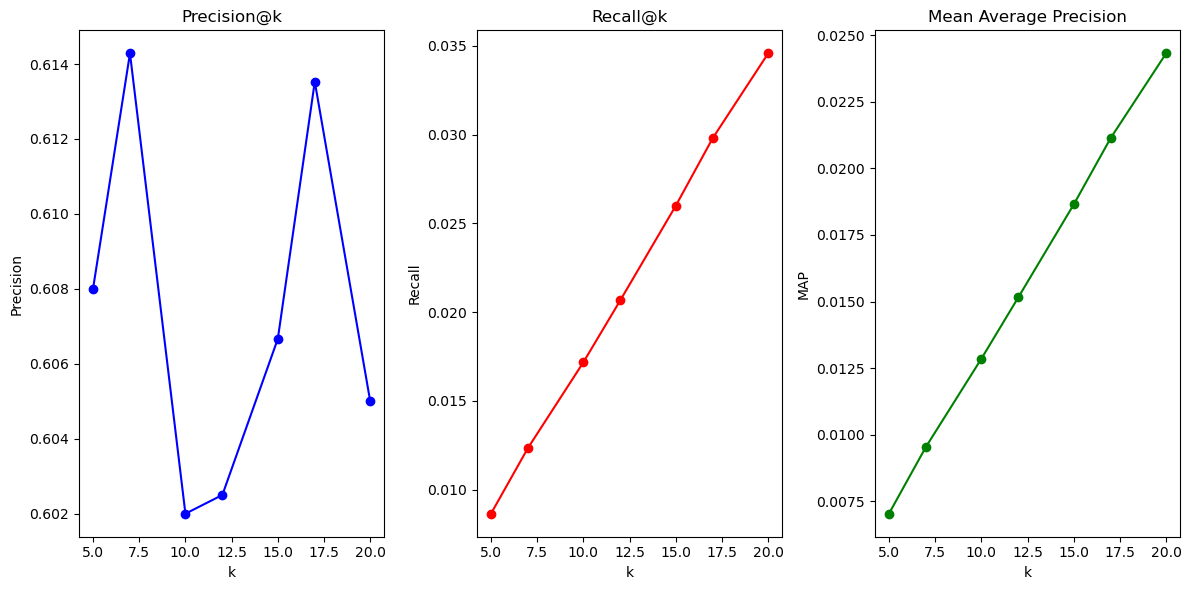


Results summary:
    k  precision@k  recall@k       MAP
0   5     0.608000  0.008637  0.007034
1   7     0.614286  0.012337  0.009540
2  10     0.602000  0.017167  0.012851
3  12     0.602500  0.020664  0.015157
4  15     0.606667  0.025986  0.018646
5  17     0.613529  0.029795  0.021141
6  20     0.605000  0.034572  0.024321


In [7]:
# Evaluate for k=5 with optimized evaluation function
k_values = [5, 7, 10, 12, 15, 17, 20]
results = {}

for k in k_values:
    print(f"\nEvaluating for k={k}")
    results[k] = evaluate_recommender(content_recommender, test_interactions, k=k, max_users=100)
    print(f"Results for k={k}:")
    print(f"Precision@{k}: {results[k]['precision@k']:.4f}")
    print(f"Recall@{k}: {results[k]['recall@k']:.4f}")
    print(f"MAP: {results[k]['MAP']:.4f}")
    print(f"Users evaluated: {results[k]['evaluated_users']}")

# Create a dataframe for visualization
results_df = pd.DataFrame({k: {metric: results[k][metric] for metric in ['precision@k', 'recall@k', 'MAP']} 
                          for k in k_values}).T
results_df.index.name = 'k'
results_df = results_df.reset_index()

# Plot the results
plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
plt.plot(results_df['k'], results_df['precision@k'], 'bo-')
plt.title('Precision@k')
plt.xlabel('k')
plt.ylabel('Precision')

plt.subplot(1, 3, 2)
plt.plot(results_df['k'], results_df['recall@k'], 'ro-')
plt.title('Recall@k')
plt.xlabel('k')
plt.ylabel('Recall')

plt.subplot(1, 3, 3)
plt.plot(results_df['k'], results_df['MAP'], 'go-')
plt.title('Mean Average Precision')
plt.xlabel('k')
plt.ylabel('MAP')

plt.tight_layout()
plt.show()

# Print the results
print("\nResults summary:")
print(results_df)